### 1. Library

In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

# 데이터 전처리에 필요한 라이브러리
from sklearn.preprocessing import MinMaxScaler

# 모델에 필요한 라이브러리
from keras import models
from keras import layers
from keras  import regularizers
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

### 2. Data Loading

In [2]:
set1 = pd.read_csv('../data/set01.csv') ; set1 = set1.set_index('Date')
set2 = pd.read_csv('../data/set02.csv') ; set2 = set2.set_index('Date')
set3 = pd.read_csv('../data/set03.csv') ; set3 = set3.set_index('Date')
set4 = pd.read_csv('../data/set04.csv') ; set4 = set4.set_index('Date')
set5 = pd.read_csv('../data/set05.csv') ; set5 = set5.set_index('Date')
set6 = pd.read_csv('../data/set06.csv') ; set6 = set6.set_index('Date')
set7 = pd.read_csv('../data/set07.csv') ; set7 = set7.set_index('Date')
set8 = pd.read_csv('../data/set08.csv') ; set8 = set8.set_index('Date')
set9 = pd.read_csv('../data/set09.csv') ; set9 = set9.set_index('Date')
set10 = pd.read_csv('../data/set10.csv') ; set10 = set10.set_index('Date')
set11 = pd.read_csv('../data/set11.csv') ; set11 = set11.set_index('Date')
set12 = pd.read_csv('../data/set12.csv') ; set12 = set12.set_index('Date')

### 3. Split Days

In [3]:
days1 = ['2019-01-31','2019-02-28','2019-03-31','2019-04-30','2019-05-31','2019-06-30',
         '2019-07-31','2019-08-31','2019-09-30','2019-10-31','2019-11-30','2019-12-31']

days2 = ['2019-02-01','2019-03-01','2019-04-01','2019-05-01','2019-06-01','2019-07-01',
         '2019-08-01','2019-09-01','2019-10-01','2019-11-01','2019-12-01','2020-01-01']

### 4. Model Build

In [4]:
# 데이터의 개수가 그렇게 많지 않으므로, 모델을 깊게 생성하지는 않는다.
def build_model():
    model = models.Sequential()

    # 1st Layer
    model.add(layers.Dense(512, 
                           kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                           activation='relu', 
                           input_shape=(train_data.shape[1],)))
    # 1st Dropout
    model.add(layers.Dropout(0.5))
        
    # 2nd Layer
    model.add(layers.Dense(512,
                           kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
                           activation='relu'))
    # 2nd Dropout
    model.add(layers.Dropout(0.5))
    
    # Result
    model.add(layers.Dense(1))

    # Model Compile
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model

### 4. Model Simulation

In [5]:
# 순서 setting을 위한 변수
order = 0

# 시간 측정을 위한 변수
times = 0

# 평균 1일 뒤 방향성 예측 정확도를 계산하기 위한 변수
acc = 0

# 예측하는 데이터의 개수
test_obs = 0

# 전체 데이터 개수
obs = len(set1) + len(set2) + len(set3) + len(set4) + len(set5) + len(set6) +\
      len(set7) + len(set8) + len(set9) + len(set10) + len(set11) + len(set12) 

# 정기 매입 가격
original_sum = 0

# 추천 매입 날짜 저장
recommend_days = []

# 상승하락 정확도 저장
UpDown = []

for data in [set1, set2, set3, set4, set5, set6, set7, set8, set9, set10, set11, set12] : 
    
    # 시간측정 시작
    start = timeit.default_timer()
    
    # 진행사항 표시
    print('{:2}번 데이터셋 시뮬레이션 진행중... 예측 기간 : {}년 {}월'.format(order+1,days2[order][0:4],days2[order][5:7]))
    print('\n')
    
    # 데이터셋 shift 진행
    past_days = 10                         

    for step in range(1, past_days+1):     
        data['shift_{}'.format(step)] = data['Rate'].shift(step)
        
    # 결측값 제거
    data = data.dropna()
    
    # Input 순서 뒤집기
    data = data[['Rate','shift_10','shift_9','shift_8','shift_7','shift_6',\
                 'shift_5', 'shift_4', 'shift_3', 'shift_2', 'shift_1']]
    
    # Train Valid Test Split
    # Train Data
    train_data = data[:days1[order]][data.columns[1:]]
    train_targets = data[:days1[order]][data.columns[0]]

    # Test Data
    test_data = data[days2[order]:][data.columns[1:]]
    test_targets = data[days2[order]:][data.columns[0]]

    # Reshape to Numpy Array : 4개의 데이터프레임을 모두 Numpy 배열로 변경.
    train_data = np.array(train_data)
    train_targets = np.array(train_targets)
    test_data = np.array(test_data)
    test_targets = np.array(test_targets)
    
    # Input에 대해서만 정규화 진행.
    # 평균이 0, 표준편차가 1인 정규분포로 데이터를 변경.
    mean = train_data.mean(axis=0)
    train_data -= mean
    std = train_data.std(axis=0)
    train_data /= std

    # 과적합을 막기위해서 Train의 정보를 이용하여, Test에 적용한다.
    test_data -= mean
    test_data /= std

    # 모델 불러오기
    model = build_model()

    # 전체 데이터로 훈련
    model.fit(train_data, train_targets, epochs=300, batch_size=500, verbose=0)
    test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
    
    # Test 점수
    print('test_mae_score = {:.4f}' .format(test_mae_score), end='\n')
    
    # 결과 저장
    result = pd.DataFrame()
    result['Date'] = set1[days2[order]:].index
    result['DNN_Model'] = model.predict(test_data).reshape(-1)
    result['Actual'] = test_targets
    result['Error'] = result['Actual'] - result['DNN_Model']
    result = result.set_index('Date')
    
    # 상승, 하락의 방향성만....!
    print(result[['DNN_Model', 'Actual']].corr())
    acc += result[['DNN_Model', 'Actual']].corr().values[0,1] * len(data)
    UpDown.append(result[['DNN_Model', 'Actual']].corr().values[0,1])
    
    # 정기매입법 가격 계산
    original_sum += np.sum(test_targets[0:15])
    
    # 5일씩 예측하기 20일만 예측
    # Test에 사용할 데이터
    test = data
    test = test[:data[days2[order]:].index.values[::5][0]][-11:-1]
    # 1일 뒤 예측
    test_sc = (np.array(test[-10:].T) - mean) / std
    pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['Future_1_Days'])
    test = test.append(pred_df)
    # 2일 뒤 예측
    test_sc = (np.array(test[-10:].T) - mean) / std
    pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['Future_2_Days'])
    test = test.append(pred_df)
    # 3일 뒤 예측
    test_sc = (np.array(test[-10:].T) - mean) / std
    pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['Future_3_Days'])
    test = test.append(pred_df)
    # 4일 뒤 예측
    test_sc = (np.array(test[-10:].T) - mean) / std
    pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['Future_3_Days'])
    test = test.append(pred_df)
    # 5일 뒤 예측
    test_sc = (np.array(test[-10:].T) - mean) / std
    pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['Future_4_Days'])
    test = test.append(pred_df)
    # 추천 매입 날짜 저장하기
    if test[test['Rate'] == test[-5:].min().values[0]].index.values[0] == 'Future_1_Days' : 
        recommend_days.append(data[days2[order]:].index[0])
    elif test[test['Rate'] == test[-5:].min().values[0]].index.values[0] == 'Future_2_Days' : 
        recommend_days.append(data[days2[order]:].index[1])
    elif test[test['Rate'] == test[-5:].min().values[0]].index.values[0] == 'Future_3_Days' : 
        recommend_days.append(data[days2[order]:].index[2])
    elif test[test['Rate'] == test[-5:].min().values[0]].index.values[0] == 'Future_4_Days' : 
        recommend_days.append(data[days2[order]:].index[3])
    elif test[test['Rate'] == test[-5:].min().values[0]].index.values[0] == 'Future_5_Days' : 
        recommend_days.append(data[days2[order]:].index[4])
    
    # 5일씩 예측하기 20일만 예측
    # Test에 사용할 데이터
    test = data
    test = test[:data[days2[order]:].index.values[::5][1]][-11:-1]
    # 1일 뒤 예측
    test_sc = (np.array(test[-10:].T) - mean) / std
    pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['Future_1_Days'])
    test = test.append(pred_df)
    # 2일 뒤 예측
    test_sc = (np.array(test[-10:].T) - mean) / std
    pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['Future_2_Days'])
    test = test.append(pred_df)
    # 3일 뒤 예측
    test_sc = (np.array(test[-10:].T) - mean) / std
    pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['Future_3_Days'])
    test = test.append(pred_df)
    # 4일 뒤 예측
    test_sc = (np.array(test[-10:].T) - mean) / std
    pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['Future_3_Days'])
    test = test.append(pred_df)
    # 5일 뒤 예측
    test_sc = (np.array(test[-10:].T) - mean) / std
    pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['Future_4_Days'])
    test = test.append(pred_df)
    # 추천 매입 날짜 저장하기
    if test[test['Rate'] == test[-5:].min().values[0]].index.values[0] == 'Future_1_Days' : 
        recommend_days.append(data[days2[order]:][5:].index[0])
    elif test[test['Rate'] == test[-5:].min().values[0]].index.values[0] == 'Future_2_Days' : 
        recommend_days.append(data[days2[order]:][5:].index[1])
    elif test[test['Rate'] == test[-5:].min().values[0]].index.values[0] == 'Future_3_Days' : 
        recommend_days.append(data[days2[order]:][5:].index[2])
    elif test[test['Rate'] == test[-5:].min().values[0]].index.values[0] == 'Future_4_Days' : 
        recommend_days.append(data[days2[order]:][5:].index[3])
    elif test[test['Rate'] == test[-5:].min().values[0]].index.values[0] == 'Future_5_Days' : 
        recommend_days.append(data[days2[order]:][5:].index[4])
    
    # 5일씩 예측하기 20일만 예측
    # Test에 사용할 데이터
    test = data
    test = test[:data[days2[order]:].index.values[::5][2]][-11:-1]
    # 1일 뒤 예측
    test_sc = (np.array(test[-10:].T) - mean) / std
    pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['Future_1_Days'])
    test = test.append(pred_df)
    # 2일 뒤 예측
    test_sc = (np.array(test[-10:].T) - mean) / std
    pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['Future_2_Days'])
    test = test.append(pred_df)
    # 3일 뒤 예측
    test_sc = (np.array(test[-10:].T) - mean) / std
    pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['Future_3_Days'])
    test = test.append(pred_df)
    # 4일 뒤 예측
    test_sc = (np.array(test[-10:].T) - mean) / std
    pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['Future_3_Days'])
    test = test.append(pred_df)
    # 5일 뒤 예측
    test_sc = (np.array(test[-10:].T) - mean) / std
    pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['Future_4_Days'])
    test = test.append(pred_df)
    # 추천 매입 날짜 저장하기
    if test[test['Rate'] == test[-5:].min().values[0]].index.values[0] == 'Future_1_Days' : 
        recommend_days.append(data[days2[order]:][10:].index[0])
    elif test[test['Rate'] == test[-5:].min().values[0]].index.values[0] == 'Future_2_Days' : 
        recommend_days.append(data[days2[order]:][10:].index[1])
    elif test[test['Rate'] == test[-5:].min().values[0]].index.values[0] == 'Future_3_Days' : 
        recommend_days.append(data[days2[order]:][10:].index[2])
    elif test[test['Rate'] == test[-5:].min().values[0]].index.values[0] == 'Future_4_Days' : 
        recommend_days.append(data[days2[order]:][10:].index[3])
    elif test[test['Rate'] == test[-5].min().values[0]].index.values[0] == 'Future_5_Days' : 
        recommend_days.append(data[days2[order]:][10:].index[4]) 
    
    # 마무리
    test_obs += len(test_data[0:15])
    order += 1
    
    # 시간측정 종료
    stop = timeit.default_timer()
    
    # 모델 진행 시간
    print('진행 시간 : {:.2f}초' .format(stop - start), end='\n')
    times += stop - start
    
    print('\n\n')

 1번 데이터셋 시뮬레이션 진행중... 예측 기간 : 2019년 02월






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


17/17 [==============================] - 0s 4ms/step
test_mae_score = 39.4278
           DNN_Model    Actual
DNN_Model   1.000000  0.369217
Actual      0.369217  1.000000
진행 시간 : 6.11초



 2번 데이터셋 시뮬레이션 진행중... 예측 기간 : 2019년 03월




/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


20/20 [==============================] - 0s 5ms/step
test_mae_score = 49.7714
           DNN_Model    Actual
DNN_Model   1.000000  0.699679
Actual      0.699679  1.000000
진행 시간 : 2.85초



 3번 데이터셋 시뮬레이션 진행중... 예측 기간 : 2019년 04월


22/22 [==============================] - 0s 5ms/step
test_mae_score = 20.1959
           DNN_Model   Actual
DNN_Model    1.00000  0.87619
Actual       0.87619  1.00000
진행 시간 : 3.02초



 4번 데이터셋 시뮬레이션 진행중... 예측 기간 : 2019년 05월


21/21 [==============================] - 0s 6ms/step
test_mae_score = 178.5033
           DNN_Model    Actual
DNN_Model   1.000000  0.909056
Actual      0.909056  1.000000
진행 시간 : 2.79초



 5번 데이터셋 시뮬레이션 진행중... 예측 기간 : 2019년 06월


19/19 [==============================] - 0s 8ms/step
test_mae_score = 127.5737
           DNN_Model    Actual
DNN_Model   1.000000  0.666046
Actual      0.666046  1.000000
진행 시간 : 3.12초



 6번 데이터셋 시뮬레이션 진행중... 예측 기간 : 2019년 07월


23/23 [==============================] - 0s 8ms/step
test_mae_score = 14.4741
   

### 5. Final Report

In [6]:
set12 = pd.read_csv('../data/set12.csv') ; set12 = set12.set_index('Date')
dnn_model = np.sum(set12[set12.index.isin(recommend_days)] * 5).values[0]

print('{:=^60}'.format(' 최종 시뮬레이션 결과 '),end='\n\n')

# 결과 요약
print('매달 총 3번의 5일 동안 최저점을 찾아 매입 시도', end='\n\n')
print('최종 시뮬레이션 소요 시간 : {:.2f} 초' .format(times), end='\n\n')
print('1일 뒤 예측 방향성(상승,하락) 정확도 : {:.2f}' .format(acc/obs), end='\n\n')
plus = original_sum - dnn_model
print('1년 동안 모델을 통해 줄인 비용 {:.2f}원, 약 {:.2f}%' . format(plus,(plus/original_sum)*100), end='\n\n')
print('100억 매입시 예상 비용 절감 금액 : {:,}원' .format(int((plus/original_sum) * 10000000000)), end='\n\n\n')

# 정기매입법
print('='*10,' 정기매입법 ', '='*10)
print('총 매입 달러 수량 : {} 달러' .format(test_obs))
print('1년 총 매입 가격 : {:,.2f}원'.format(original_sum))
print('평균 1달러 매입 가격 : {:,.2f}원'.format(original_sum / test_obs))
print('='*32, end='\n\n\n')

# DNN Model
print('='*10,' DNN Model ', '='*10)
print('총 매입 달러 수량 : {} 달러' .format(test_obs))
print('1년 총 매입 가격 : {:,.2f}원'.format(dnn_model))
print('평균 1달러 매입 가격 : {:,.2f}원'.format(dnn_model / test_obs))
print('='*33, end='\n\n')

print('='*66)

======================= 최종 시뮬레이션 결과 ========================

매달 총 3번의 5일 동안 최저점을 찾아 매입 시도

최종 시뮬레이션 소요 시간 : 41.65 초

1일 뒤 예측 방향성(상승,하락) 정확도 : 0.67

1년 동안 모델을 통해 줄인 비용 -28.90원, 약 -0.01%

100억 매입시 예상 비용 절감 금액 : -1,373,704원


==========  정기매입법  ==========
총 매입 달러 수량 : 180 달러
1년 총 매입 가격 : 210,380.10원
평균 1달러 매입 가격 : 1,168.78원


==========  DNN Model  ==========
총 매입 달러 수량 : 180 달러
1년 총 매입 가격 : 210,409.00원
평균 1달러 매입 가격 : 1,168.94원



### 6. Up & Down Prediction

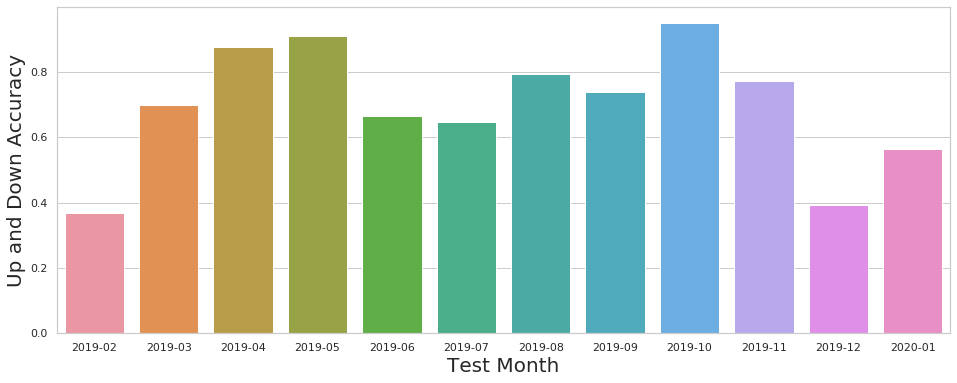

In [7]:
result = pd.DataFrame({'Accuracy':UpDown, 'Month':['2019-02','2019-03','2019-04','2019-05','2019-06','2019-07',\
                                                  '2019-08','2019-09','2019-10','2019-11','2019-12','2020-01']})

sns.set(rc={'figure.figsize':(16,6)})
sns.set(style="whitegrid")
ax = sns.barplot(x="Month", y="Accuracy", data=result)
ax.set_ylabel('Up and Down Accuracy', size=20)
ax.set_xlabel('Test Month', size=20)
plt.show()